## Hand writting (Digit) classification

In [8]:
import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
% matplotlib inline
import os
import numpy as np
import cv2

In [9]:
#load mnist dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [10]:
# Printing the shape of the Train and test Data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [18]:
cDir=os.getcwd()
for i in range(len(X_test)):
    image=X_test[i,:,:]
    img=image.reshape(28,28)
    number='%04d'%i
    path=cDir+'/test/'+str(number)+'.png'
    cv2.imwrite(path,img)

In [12]:
# Comments
# There are 60000 images in Training with the size 28x28
# There are 10000 images in Test with the size 28x28

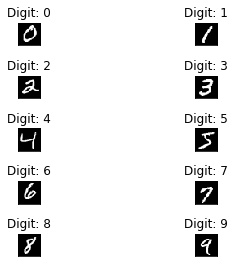

In [13]:
# Plot 0~9 Hand written digits for understanding
x=np.unique(y_train)
unique=[]

for i in range(len(x)):
    number=x[i]
    for j in range(len(y_train)):
        getNumber=y_train[j]
        if getNumber==number:
            unique.append(j)
            break
    
    

fig = plt.figure()
for i in range(10):
    index=unique[i]
    plt.subplot(5,2,i+1)
    plt.tight_layout()
    plt.imshow(X_train[index], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(y_train[index]))
    plt.xticks([])
    plt.yticks([])
